In [1]:
from dataset import Dataset
import torch
from torch import nn 
import torch.optim as optim
from torch.utils import data
import time
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms as T
import qrcode
import random
from config import Config as op
import os

In [2]:
web_path = op.web_root
lfw_path = op.lfw_root
carrier_list = op.carrier_list
p_num = op.carrier_num

In [3]:
with open(os.path.join(carrier_list), 'r') as fd:
    carriers = fd.readlines()

carriers = [os.path.join(lfw_path, carr[:-1]) for carr in carriers]
normalize = T.Normalize(mean=[0.5], std=[0.5])
img_transforms = T.Compose([
    T.CenterCrop((128,128)),
    T.ToTensor(),
    normalize
])

datasets = []
for i in range(len(carriers)):
    sample = carriers[i]
    splits = sample.split()
    img_path = splits[0]
    data = Image.open(img_path)
    data = data.convert('L')  
    data = img_transforms(data)
    datasets.append(data)

/home/zhuomengzhang/.conda/envs/torch_p36/lib/python3.6/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


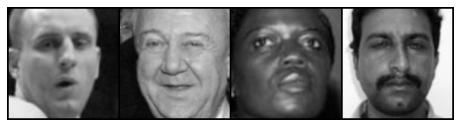

In [4]:
def show_imgs(imgs):
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,4))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

show_imgs([datasets[i] for i in range(4)])

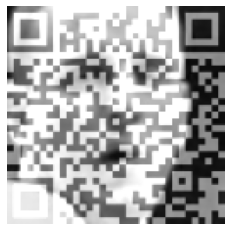

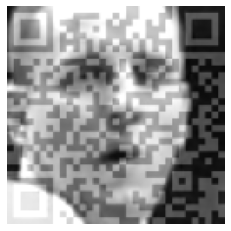

In [5]:
def QR_gen(key):
    qr = qrcode.QRCode(
        version=4,
        error_correction=qrcode.constants.ERROR_CORRECT_Q,
        box_size=4,
        border=0,
    )
    qr.add_data(str(key))
    img = qr.make_image()
    img.save("qrcode.png")

    Img = Image.open("qrcode.png").convert('L')
    return Img

qr_transform = T.Compose([
    T.ToTensor(),
    T.Resize(128)
])

# 生成个人信息：以key生成二维码
key = random.getrandbits(256)
qr_img = QR_gen(key)
qr_img = qr_transform(qr_img).to(torch.float)

sig = qr_img.reshape(-1, 1, 128, 128) #所谓签名
show_imgs(sig+datasets[0])
# a = 0.1被AE滤去
a = 0.5
sig = 0.5*sig
show_imgs(sig+datasets[0])

In [6]:
device = torch.device("cuda:3")

w1 = torch.rand(128*128)
w1 = w1.reshape(-1, 1, 128, 128) #与AE输入输出一致
w1 = w1.to(device)
w1.requires_grad_(True)
sig = sig.to(device)

In [8]:
class EnDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=2),   #128 => 64
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 2*16, kernel_size=3, padding=1, stride=2),   #64 => 32
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*16, 3*16, kernel_size=3, padding=1, stride=2),   #32 => 16
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(3*16, 4*16, kernel_size=3, padding=1, stride=2),   #16 => 8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(4*16, 5*16, kernel_size=3, padding=1, stride=2),   #8 => 4
            nn.GELU(),
            nn.Flatten(),   #Image grid to single feature vector
            nn.Linear(5*16*16, 512)   #特征向量压缩到384维
        )
        
        self.linear = nn.Sequential(
            nn.Linear(512, 5*16*16),
            nn.GELU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(5*16, 4*16, kernel_size=3, output_padding=1, padding=1, stride=2),   #4 => 8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(4*16, 3*16, kernel_size=3, output_padding=1, padding=1, stride=2),   #8 => 16
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(3*16, 2*16, kernel_size=3, output_padding=1, padding=1, stride=2),   #16 => 32
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*16, 16, kernel_size=3, output_padding=1, padding=1, stride=2),   #32 => 64
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, output_padding=1, padding=1, stride=2),   #64 => 128
            nn.Tanh()   #The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.Decoder(x)
        return x

AE1 = EnDecoder()
AE1.load_state_dict(torch.load("AEs/AE1.pt"))
AE1.to(device)
AE1.eval()

AE2 = EnDecoder()
AE2.load_state_dict(torch.load("AEs/AE2.pt"))
AE2.to(device)
AE2.eval()

AE3 = EnDecoder()
AE3.load_state_dict(torch.load("AEs/AE3.pt"))
AE3.to(device)
AE3.eval()   #作为攻击者AE

AE4 = EnDecoder()
AE4.load_state_dict(torch.load("AEs/AE4.pt"))
AE4.to(device)
AE4.eval()

AE5 = EnDecoder()
AE5.load_state_dict(torch.load("AEs/AE5.pt"))
AE5.to(device)
AE5.eval()

EnDecoder(
  (Encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): GELU()
    (12): Conv2d(48, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): GELU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GELU()
    (16): Conv2d(64, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (17): GELU()
    (18): Flatten(start_dim=1, end_dim=-1)
    (19): Linear(in_features=1280, out_features=512, bias=True)
  )
  (linear): Sequential(
   

In [10]:
iter_num = 3000 #迭代轮数
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam([w1], lr=1e-3)

for ii in range(iter_num):
    loss = 0
    start = time.process_time()
    
    for i in range(p_num):
        image = datasets[i].to(device) + w1
        op1 = AE1(image)
        op2 = AE2(image)
        #op3 = AE3(image)
        op4 = AE4(image)
        op5 = AE5(image)   
        
        loss = loss + loss_function(w1, op1)
        loss = loss + loss_function(w1, op2)
        loss = loss + loss_function(w1, op4)
        loss = loss + loss_function(w1, op5)

    optimizer.zero_grad()
    loss = loss + 0.02*torch.sum((w1-sig)**2)
    loss.backward()
    optimizer.step()
    
    if (ii%100)==0:
        print("iter: %i loss: %f" %(ii,loss/p_num))
        print("Elapsed time = %f" %(time.process_time()-start))
        start = time.process_time()

iter: 0 loss: 1.674400
Elapsed time = 1.848926
iter: 100 loss: 1.362600
Elapsed time = 1.836806
iter: 200 loss: 1.171634
Elapsed time = 1.753760
iter: 300 loss: 1.050931
Elapsed time = 1.911265
iter: 400 loss: 0.972212
Elapsed time = 1.770807
iter: 500 loss: 0.913849
Elapsed time = 1.790342
iter: 600 loss: 0.845047
Elapsed time = 1.797475
iter: 700 loss: 0.811837
Elapsed time = 1.807661
iter: 800 loss: 0.790845
Elapsed time = 1.807248
iter: 900 loss: 0.777422
Elapsed time = 1.738853
iter: 1000 loss: 0.768964
Elapsed time = 1.724878
iter: 1100 loss: 0.763747
Elapsed time = 1.724531
iter: 1200 loss: 0.760607
Elapsed time = 1.737334
iter: 1300 loss: 0.758765
Elapsed time = 1.732997
iter: 1400 loss: 0.757713
Elapsed time = 1.756100
iter: 1500 loss: 0.757128
Elapsed time = 1.740444
iter: 1600 loss: 0.756812
Elapsed time = 1.743854
iter: 1700 loss: 0.756646
Elapsed time = 1.743428
iter: 1800 loss: 0.756561
Elapsed time = 1.732632
iter: 1900 loss: 0.756519
Elapsed time = 1.746589
iter: 2000 l

In [30]:
import numpy as np
def save_img(image, filename):
    img = image.reshape(128,128)
    img = img.detach().numpy()
    #print(np.min(img))
    #print(np.max(img))
    img = (img-np.min(img))/(np.max(img)-np.min(img))    #防止数值越界
    Image.fromarray(np.uint8(img*255)).convert('L').save(filename)

/home/zhuomengzhang/.conda/envs/torch_p36/lib/python3.6/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


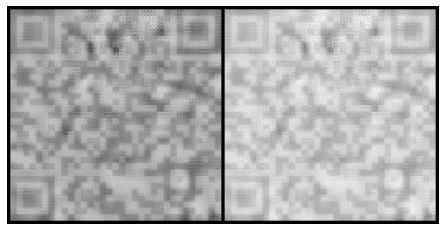

torch.Size([1, 128, 128])

In [31]:
save_img(w1.cpu(), "w1.jpg")
w11 = Image.open("w1.jpg").convert('L')
w11 = qr_transform(w11)
show_imgs([w1.cpu().reshape(1,128,128), w11])
w11.shape

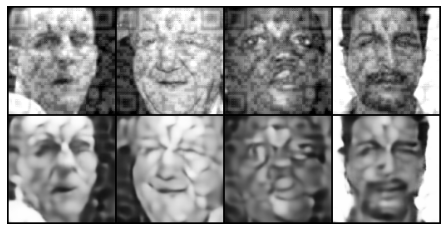

In [32]:
# 肉眼测试下AE的效果
input_imgs = torch.stack([datasets[i] for i in range(4)], dim=0)
test_imgs = torch.cat([(image + w1.cpu()) for image in input_imgs], dim=0)
AE_imgs = AE3(test_imgs.to(device))

show_imgs(torch.cat([test_imgs, AE_imgs.cpu()], dim=0))

In [33]:
save_dir = os.path.join(web_path, "0000001")
for i in range(p_num):
    img_path = os.path.join(save_dir, str(i)+".jpg")
    img = datasets[i] + w1.cpu()
    save_img(img, img_path)